# Linear and Integer Programming

<a href="https://colab.research.google.com/github/pedromxavier/QUBO-notebooks/blob/main/notebooks/1-LP_IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
    <img src="https://raw.githubusercontent.com/psrenergy/QUBO.jl/master/docs/src/assets/logo.svg" width="400px" alt="QUBO.jl">
</div>

## Notebook Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This can take a couple of minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

_Adapted from [this notebook](https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_Colab_Notebook_Template.ipynb)._

In [ ]:
%%shell
set -e

JULIA_VERSION="1.9.0" # any version ≥ 0.7.0
JULIA_NUM_THREADS=2

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  URL="$https://julialang-s3.julialang.org/bin/linux/x64/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install kernel and rename it to "julia"
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict("JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo "Successfully installed `julia -v`! Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then jump to the 'Checking the Installation' section."
fi

# Install Packages

In [1]:
using Pkg

Pkg.activate(; temp=true);

Pkg.add.([
    "JuMP",
    "GLPK",
    "Cbc",
    "Ipopt",
    "AmplNLWriter",
    "Bonmin_jll",
    "Couenne_jll",
    "Plots",
    "SpecialFunctions",
]);

  Activating new project at `/tmp/jl_sDWz4W`


    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


    Updating `/tmp/jl_sDWz4W/Project.toml`
  [4076af6c] + JuMP v1.11.1
    Updating `/tmp/jl_sDWz4W/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.3.2
  [d360d2e6] + ChainRulesCore v1.16.0
  [9e997f8a] + ChangesOfVariables v0.1.7
  [523fee87] + CodecBzip2 v0.7.2
  [944b1d66] + CodecZlib v0.7.1
  [bbf7d656] + CommonSubexpressions v0.3.0
  [34da2185] + Compat v4.6.1
  [864edb3b] + DataStructures v0.18.13
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [ffbed154] + DocStringExtensions v0.9.3
  [f6369f11] + ForwardDiff v0.10.35
  [3587e190] + InverseFunctions v0.1.9
  [92d709cd] + IrrationalConstants v0.2.2
  [692b3bcd] + JLLWrappers v1.4.1
  [682c06a0] + JSON v0.21.4
  [4076af6c] + JuMP v1.11.1
  [2ab3a3ac] + LogExpFunctions v0.3.24
  [1914dd2f] + MacroTools v0.5.10
  [b8f27783] + MathOptInterface v1.17.1
  [d8a4904e] + MutableArithmetics v1.3.0
  [77ba4419] + NaNMath v1.0.2
  [bac558e1] + OrderedCollections v1.6.0
  [69de0a69] + Parsers v2.7.0
  [aea7be01] + Precomp

   Resolving package versions...
    Updating `/tmp/jl_sDWz4W/Project.toml`
  [60bf3e95] + GLPK v1.1.2
    Updating `/tmp/jl_sDWz4W/Manifest.toml`
  [60bf3e95] + GLPK v1.1.2
  [e8aa6df9] + GLPK_jll v5.0.1+0
  [781609d7] + GMP_jll v6.2.1+2


   Resolving package versions...
    Updating `/tmp/jl_sDWz4W/Project.toml`
  [9961bab8] + Cbc v1.1.1
    Updating `/tmp/jl_sDWz4W/Manifest.toml`
  [9961bab8] + Cbc v1.1.1
  [ae81ac8f] + ASL_jll v0.1.3+0
  [38041ee0] + Cbc_jll v200.1000.800+0
  [3830e938] + Cgl_jll v0.6000.600+0
  [06985876] + Clp_jll v100.1700.700+1
  [be027038] + CoinUtils_jll v200.1100.600+0
  [d00139f3] + METIS_jll v5.1.2+0
⌅ [d7ed1dd3] + MUMPS_seq_jll v500.500.101+0
⌅ [656ef2d0] + OpenBLAS32_jll v0.3.17+0
  [7da25872] + Osi_jll v0.10800.700+0
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`


   Resolving package versions...
    Updating `/tmp/jl_sDWz4W/Project.toml`
⌃ [b6b21f68] + Ipopt v1.4.0
    Updating `/tmp/jl_sDWz4W/Manifest.toml`
⌃ [b6b21f68] + Ipopt v1.4.0
⌅ [9cc047cb] + Ipopt_jll v300.1400.1200+0
        Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated -m`


   Resolving package versions...
    Updating `/tmp/jl_sDWz4W/Project.toml`
⌃ [7c4d4715] + AmplNLWriter v1.0.1
    Updating `/tmp/jl_sDWz4W/Manifest.toml`
⌃ [7c4d4715] + AmplNLWriter v1.0.1
        Info Packages marked with ⌃ have new versions available and may be upgradable.


   Resolving package versions...
    Updating `/tmp/jl_sDWz4W/Project.toml`
  [29cba6d7] + Bonmin_jll v100.800.801+0
    Updating `/tmp/jl_sDWz4W/Manifest.toml`
  [29cba6d7] + Bonmin_jll v100.800.801+0


   Resolving package versions...
    Updating `/tmp/jl_sDWz4W/Project.toml`
  [f09e9e23] + Couenne_jll v0.500.801+0
    Updating `/tmp/jl_sDWz4W/Manifest.toml`
  [f09e9e23] + Couenne_jll v0.500.801+0


   Resolving package versions...


    Updating `/tmp/jl_sDWz4W/Project.toml`
  [91a5bcdd] + Plots v1.38.16
    Updating `/tmp/jl_sDWz4W/Manifest.toml`
  [d1d4a3ce] + BitFlags v0.1.7
  [35d6a980] + ColorSchemes v3.21.0
  [3da002f7] + ColorTypes v0.11.4
  [c3611d14] + ColorVectorSpace v0.9.10
  [5ae59095] + Colors v0.12.10
  [f0e56b4a] + ConcurrentUtilities v2.2.0
  [187b0558] + ConstructionBase v1.5.2
  [d38c429a] + Contour v0.6.2
  [9a962f9c] + DataAPI v1.15.0
  [c87230d0] + FFMPEG v0.4.1
  [53c48c17] + FixedPointNumbers v0.8.4
  [59287772] + Formatting v0.4.2
  [28b8d3ca] + GR v0.72.7
  [42e2da0e] + Grisu v1.0.2
  [cd3eb016] + HTTP v1.9.6
  [1019f520] + JLFzf v0.1.5
  [b964fa9f] + LaTeXStrings v1.3.0
  [23fbe1c1] + Latexify v0.16.1
  [e6f89c97] + LoggingExtras v1.0.0
  [739be429] + MbedTLS v1.1.7
  [442fdcdd] + Measures v0.3.2
  [e1d29d7a] + Missings v1.1.0
  [4d8831e6] + OpenSSL v1.4.1
  [b98c9c47] + Pipe v1.3.0
  [ccf2f8ad] + PlotThemes v3.1.0
  [995b91a9] + PlotUtils v1.3.5
  [91a5bcdd] + Plots v1.38.16
  [3cdcf5f2

   Resolving package versions...


    Updating `/tmp/jl_sDWz4W/Project.toml`
  [276daf66] + SpecialFunctions v2.2.0
  No Changes to `/tmp/jl_sDWz4W/Manifest.toml`


## Introduction to Mathematical Programming

### Modeling
The solution to optimization problems requires the development of a mathematical model. Here we will model an example given in the lecture and see how an integer program can be solved practically. This example will use as modeling language **[Pyomo](http://www.pyomo.org/)**. This open-source Python package provides flexible access to different solvers and a general modeling framework for linear and nonlinear integer programs.
The examples solved here will make use of open-source solvers **[GLPK](https://www.gnu.org/software/glpk/)** and **[CLP/CBC](https://projects.coin-or.org/Cbc)** for linear and mixed-integer linear programming, **[IPOPT](https://coin-or.github.io/Ipopt/)** for interior point (non)linear programming, **[BONMIN](https://www.coin-or.org/Bonmin/)** for convex integer nonlinear programming, and **[COUENNE](https://projects.coin-or.org/Couenne)** for nonconvex (global) integer nonlinear programming.

#### Problem statement

Suppose there is a company that produces two different products, A and B, which can be sold at different values, \$5.5 and \$2.1 per unit, respectively.
The company only counts with a single machine with electricity usage of at most 17kW/day. Producing each A and B consumes 8kW/day and 2kW/day, respectively.
Besides, the company can only produce at most 2 more units of B than A per day.

### Linear Programming
This is a valid model, but it would be easier to solve if we had a mathematical representation.
Assuming the units produced of A are $x_1$ and of B are $x_2$ we have

$$
\begin{array}{rl}
    \displaystyle%
    \max_{x_1, x_2} & 5.5x_1 + 2.1x_2 \\
    \textrm{s.t.}   & x_2 \le x_1 + 2 \\
                    & 8x_1 + 2x_2 \le 17 \\
                    & x_1, x_2 \ge 0
\end{array}
$$

In [2]:
using JuMP
using GLPK, Cbc, Ipopt
using AmplNLWriter, Bonmin_jll, Couenne_jll
using Plots
using SpecialFunctions

const Bonmin_Optimizer = () -> AmplNLWriter.Optimizer(Bonmin_jll.amplexe)
const Couenne_Optimizer = () -> AmplNLWriter.Optimizer(Couenne_jll.amplexe);

In [3]:
# Define the model
model = Model()

#Define the variables
@variable(model, x[1:2] >= 0)

# Define the objective function
@objective(model, Max, 5.5x[1] + 2.1x[2])

# Define the constraints
@constraint(model, c1, x[2] <= x[1] + 2)

@constraint(model, c2, 8x[1] + 2x[2] <= 17)

# Print the model
print(model)

Max 5.5 x[1] + 2.1 x[2]
Subject to
 

c1 : -x[1] + x[2] ≤ 2
 c2 : 8 x[1] + 2 x[2] ≤ 17
 x[1] ≥ 0
 x[2] ≥ 0


In [4]:
glpk_model = copy(model)
set_optimizer(glpk_model, GLPK.Optimizer)
set_silent(glpk_model)

cbc_model = copy(model)
set_optimizer(cbc_model, Cbc.Optimizer)
set_silent(cbc_model)

In [5]:
# Here we solve the optimization problem
optimize!(glpk_model)

In [6]:
# Display solution of the problem
print(solution_summary(glpk_model))

x_ = value.(glpk_model[:x])

* Solver : GLPK

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Solution is optimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 1.40800e+01
  Objective bound    : Inf
  Dual objective value : 1.40800e+01

* Work counters
  Solve time (sec)   : 5.72205e-05


2-element Vector{Float64}:
 1.3
 3.3

We observe that the optimal solution of this problem is $x_1 = 1.3$, $x_2 = 3.3$, leading to a profit of $14.08$.

In [7]:
# We obtain the same solution with CBC
optimize!(cbc_model)

print(solution_summary(cbc_model))

x_ = value.(cbc_model[:x])

* Solver : COIN Branch-and-Cut (Cbc)

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Cbc_status          = finished - check isProvenOptimal or isProvenInfeasible to see if solution found (or check value of best solution)
Cbc_secondaryStatus = unset (status_ will also be -1)
"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 1.40800e+01
  Objective bound    : 1.40800e+01
  Relative gap       : 0.00000e+00

* Work counters
  Solve time (sec)   : 3.99113e-04
  Node count         : 0
Presolve 0 (-2) rows, 0 (-2) columns and 0 (-4) elements
Optimal - objective value 14.08
After Postsolve, objective 14.08, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 14.08 - 0 iterations time 0.002, Presolve 0.00


2-element Vector{Float64}:
 1.3
 3.3

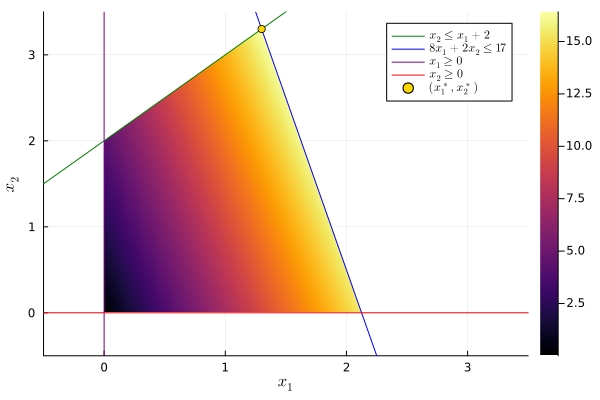

In [8]:
# Generate the feasible region plot of this problem
n = 1_000

x1 = x2 = range(-0.5, 3.5, n)

# Constraints
c(x1, x2) = (x1 >= 0)      && # Bound: x1 ≥ 0
            (x2 >= 0)      && # Bound: x2 ≥ 0
            (x2 <= x1 + 2) && # Constraint 1: x₂ ≤ x₁ + 2
            (8x1 + 2x2 <= 17) # Constraint 2: 8 x₁ + 2 x₂ ≤ 17

# Objective: min 7.3x₁ + 2.1x₂
z(x1, x2) = 7.3x1 + 2.1x2

# Plot feasible region
plt = heatmap(
    x1,
    x2,
    (x1, x2) -> c(x1, x2) ? z(x1, x2) : NaN;
    legend=:topright,
    xlims=extrema(x1),
    ylims=extrema(x2),
    xlabel=raw"$ x_1 $",
    ylabel=raw"$ x_2 $",
)

# Make plots of constraints
plot!(plt, x1, (x1) -> x1 + 2;
    label=raw"$ x_2 \leq x_1 + 2 $",
    color=:green,
)
plot!(plt, x1, (x1) -> (17 - 8x1) / 2;
    label=raw"$ 8 x_1 + 2 x_2 \leq 17 $",
    color=:blue,
)

# Nonnegativitivy constraints
plot!(plt, zeros(n), x2;
    label=raw"$ x_1 \geq 0 $",
    color=:purple,
)
plot!(plt, x1, zeros(n);
    label=raw"$ x_2 \geq 0 $",
    color=:red,
)

# Optimal solution LP
scatter!(plt, [x_[1]], [x_[2]];
    label=raw"$ (x_1^\ast, x_2^\ast) $",
    color=:gold
)

The solvers GLPK and CLP implement the simplex method (with many improvements) by default, but we can also use an interior point method through the solver IPOPT (interior point optimizer). IPOPT is able to solve not only linear but also nonlinear problems.

In [9]:
ipopt_model = copy(model)

set_optimizer(ipopt_model, Ipopt.Optimizer)
set_silent(ipopt_model)

In [10]:
optimize!(ipopt_model)

print(solution_summary(ipopt_model))

x_ = value.(ipopt_model[:x])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

* Solver : Ipopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 1.40800e+01
  Dual objective value : 1.40800e+01

* Work counters
  Solve time (sec)   : 2.59395e-01


2-element Vector{Float64}:
 1.3000000135344931
 3.300000029213091

We obtain the same result as previously, but notice that the interior point method reports a solution subject to a certain tolerance, given by its convergence properties when it can get infinitesimally close (but not directly at) the boundary of the feasible region.

## Let's go back to the slides

### Integer Programming

Now let's consider that only integer units of each product can be produced, namely

$$
\begin{array}{rl}
    \displaystyle%
    \max_{x_1, x_2} & 5.5x_1 + 2.1x_2 \\
    \textrm{s.t.}   & x_2 \leq x_1 + 2 \\
                    & 8x_1 + 2x_2 \leq 17 \\
                    & x_1, x_2 \geq 0 \\
                    & x_1, x_2 \in \mathbb{Z}
\end{array}
$$

In [11]:
# Define the model w/ Cbc
cbc_int_model = Model(Cbc.Optimizer)

# x₁, x₂ ≥ 0; x₁, x₂ ∈ ℤ
@variable(cbc_int_model, x[1:2] >= 0, Int)

# max 5.5x₁ + 2.1x₂
@objective(cbc_int_model, Max, 5.5x[1] + 2.1x[2])

# x₂ ≤ x₁ + 2
@constraint(cbc_int_model, c1, x[2] <= x[1] + 2)

# 8 x₁ + 2 x₂ ≤ 17
@constraint(cbc_int_model, c2, 8x[1] + 2x[2] <= 17)

# Settings
set_silent(cbc_int_model)

# Print the model
print(cbc_int_model)

Max 5.5 x[1] + 2.1 x[2]
Subject to
 

c1 : -x[1] + x[2] ≤ 2
 c2 : 8 x[1] + 2 x[2] ≤ 17
 x[1] ≥ 0
 x[2] ≥ 0
 x[1] integer
 x[2] integer


In [12]:
optimize!(cbc_int_model)

print(solution_summary(cbc_int_model))

xi = value.(cbc_int_model[:x])

* Solver : COIN Branch-and-Cut (Cbc)

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Cbc_status          = finished - check isProvenOptimal or isProvenInfeasible to see if solution found (or check value of best solution)
Cbc_secondaryStatus = search completed with solution
"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 1.18000e+01
  Objective bound    : 1.18000e+01
  Relative gap       : 0.00000e+00

* Work counters
  Solve time (sec)   : 2.76685e-03
  Node count         : 0


2-element Vector{Float64}:
 1.0
 3.0

Here the solution becomes $x_1 = 1, x_2 = 3$ with an objective of $11.8$.

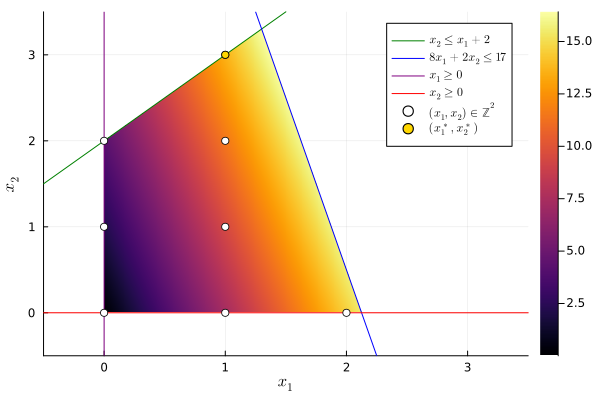

In [13]:
# Generate the feasible region plot of this problem
n = 1_000

xi1 = xi2 = 0:4

# Plot relaxed feasible region
plt = heatmap(
    x1,
    x2,
    (x1, x2) -> c(x1, x2) ? z(x1, x2) : NaN;
    legend=:topright,
    xlims=extrema(x1),
    ylims=extrema(x2),
    xlabel=raw"$ x_1 $",
    ylabel=raw"$ x_2 $",
)

# Make plots of constraints
plot!(plt, x1, (x1) -> x1 + 2;
    label=raw"$ x_2 \leq x_1 + 2 $",
    color=:green,
)
plot!(plt, x1, (x1) -> (17 - 8x1) / 2;
    label=raw"$ 8 x_1 + 2 x_2 \leq 17 $",
    color=:blue,
)

# Nonnegativitivy constraints
plot!(plt, zeros(n), x2;
    label=raw"$ x_1 \geq 0 $",
    color=:purple,
)
plot!(plt, x1, zeros(n);
    label=raw"$ x_2 \geq 0 $",
    color=:red,
)

# Feasible solutions
scatter!(plt,
    [xi1[i] for i = 1:5 for j = 1:5 if c(xi1[i], xi2[j])],
    [xi2[j] for i = 1:5 for j = 1:5 if c(xi1[i], xi2[j])];
    label=raw"$ (x_1, x_2) \in \mathbb{Z}^2 $",
    color=:white,
)

# Optimal solution LP
scatter!(plt, [xi[1]], [xi[2]];
    label=raw"$ (x_1^\ast, x_2^\ast) $",
    color=:gold,
)

## Let's go back to the slides

#### Enumeration
Enumerating all the possible solutions in this problem might be very efficient (there are only 8 feasible solutions), this we only know from the plot. Assuming that we had as upper bounds for the variables 4, the possible solutions would be 16. With a larger number of variables, the enumeration turns to be impractical. For $n$ binary variables (we can always "binarize" the integer variables), the number of possible solutions is $2^n$.

In many other applications, the possible solutions come from permutations of the integer variables (e.g., assignment problems), which grow as $n!$ with the size of the input.

This growth makes the problem grow out of control relatively quickly.

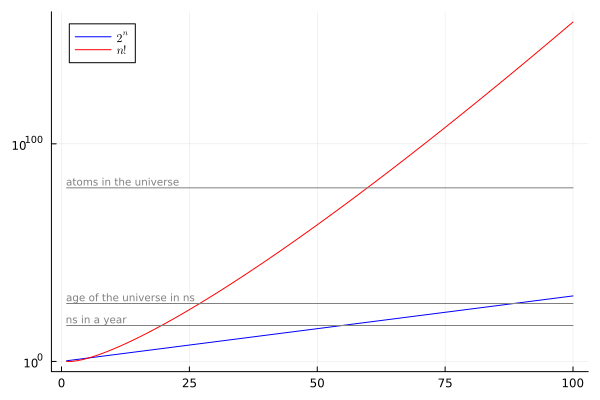

In [14]:
i = 1:100

plt = plot(i, (i) -> 2.0^i;
    label=raw"$ 2^n $",
    color=:blue,
    legend=:topleft,
    yscale=:log10,
)
plot!(plt, i, gamma; label=raw"$ n! $", color=:red)

plot!(plt, i, (i) -> 3.154E16; color=:gray, label = nothing)
annotate!(plt, first(i), 3.154E16, text("ns in a year", :gray, :left, :bottom, 7))

plot!(plt, i, (i) -> 4.3E26; color=:gray, label = nothing)
annotate!(plt, first(i), 4.3E26, text("age of the universe in ns", :gray, :left, :bottom, 7))

plot!(plt, i, (i) -> 6E79; color=:gray, label = nothing)
annotate!(plt, first(i), 6E79, text("atoms in the universe", :gray, :left, :bottom, 7))


## Let's go back to the slides

### Integer convex nonlinear programming

The following constraint: "the production of B minus 1, squared, can only be smaller than 2 minus the production of A" can be incorporated  in the following convex integer nonlinear program, 

$$
\begin{array}{rl}
    \displaystyle%
    \max_{x_1, x_2} & 5.5x_1 + 2.1x_2        \\
    \textrm{s.t.}   & x_2 \leq x_1 + 2       \\
                    & 8x_1 + 2x_2 \leq 17    \\
                    & (x_2-1)^2 \leq 2 - x_1 \\
                    & x_1, x_2 \geq 0        \\
                    & x_1, x_2 \in \mathbb{Z}
\end{array}
$$

In [15]:
# Define the model w/ Bonmin
bonmin_model = Model(Bonmin_Optimizer)

# x₁, x₂ ≥ 0; x₁, x₂ ∈ ℤ
@variable(bonmin_model, x[1:2] >= 0, Int)

# max 5.5x₁ + 2.1x₂
@objective(bonmin_model, Max, 5.5x[1] + 2.1x[2])

# x₂ ≤ x₁ + 2
@constraint(bonmin_model, c1, x[2] <= x[1] + 2)

# 8 x₁ + 2 x₂ ≤ 17
@constraint(bonmin_model, c2, 8x[1] + 2x[2] <= 17)

# (x₂ - 1)² ≤ 2 - x₁
@constraint(bonmin_model, c3, (x[2] - 1)^2 <= 2 - x[1])

# Print the model
print(bonmin_model)

Max 5.5 x[1] + 2.1 x[2]
Subject to
 

c1 : -x[1] + x[2] ≤ 2
 c2 : 8 x[1] + 2 x[2] ≤ 17
 c3 : x[2]² + x[1] - 2 x[2] ≤ 1
 x[1] ≥ 0
 x[2] ≥ 0
 x[1] integer
 x[2] integer


In [16]:
optimize!(bonmin_model)

print(solution_summary(bonmin_model))

xnl = value.(bonmin_model[:x])

Bonmin 1.8.8 using Cbc 2.10.5 and Ipopt 3.14.4
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -12.775        9 0.004942
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1      INFEAS 0.24999981       16 0.039344
NLP0014I             2         OPT -12.4125        5 1e-06
NLP0014I             3         OPT -9.7000002        6 0
NLP0014I             4         OPT -9.7000001        6 0.029286
NLP0014I             5      INFEAS 0.24999981       

NLP0014I             6         OPT -9.7000001        6 0.005419
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -9.7        0 0
Cbc0004I Integer solution of -9.7 found after 6 iterations and 0 nodes (0.10 seconds)
Cbc0001I Search completed - best objective -9.699999999999999, took 6 iterations and 0 nodes (0.10 seconds)
Cbc0032I Strong branching done 2 times (33 iterations), fathomed 0 nodes and fixed 1 variables
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost

 	"Finished"


* Solver : AmplNLWriter

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "bonmin: Optimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 9.70000e+00
  Dual objective value : 9.70000e+00

* Work counters
  Solve time (sec)   : 1.97165e-01


2-element Vector{Float64}:
 1.0
 2.0

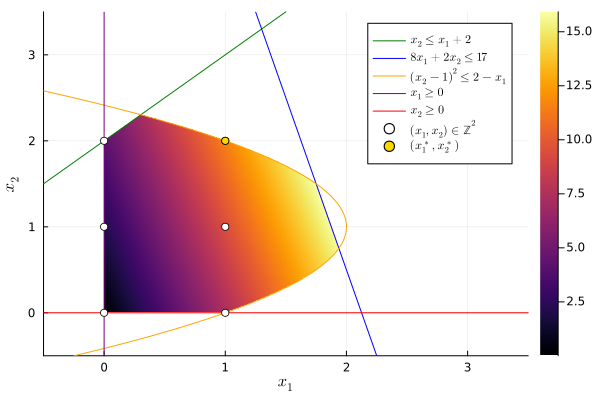

In [17]:
χ(x1, x2) = c(x1, x2) && ((x2 - 1)^2 <= 2 - x1) # Constraint 3: (x₂ - 1)² ≤ 2 - x₁

# Generate the feasible region plot of this problem
n = 1_000

xi1 = xi2 = 0:4

# Plot relaxed feasible region
plt = heatmap(
    x1,
    x2,
    (x1, x2) -> χ(x1, x2) ? z(x1, x2) : NaN;
    legend=:topright,
    xlims=extrema(x1),
    ylims=extrema(x2),
    xlabel=raw"$ x_1 $",
    ylabel=raw"$ x_2 $",
)

# Make plots of constraints
plot!(plt, x1, (x1) -> x1 + 2;
    label=raw"$ x_2 \leq x_1 + 2 $",
    color=:green,
)
plot!(plt, x1, (x1) -> (17 - 8x1) / 2;
    label=raw"$ 8 x_1 + 2 x_2 \leq 17 $",
    color=:blue,
)
plot!(plt, 2 .- (x1 .- 1) .^ 2, x1,;
    label=raw"$ (x_2 - 1)^2 \leq 2 - x_1 $",
    color=:orange,
)

# Nonnegativitivy constraints
plot!(plt, zeros(n), x2;
    label=raw"$ x_1 \geq 0 $",
    color=:purple,
)
plot!(plt, x1, zeros(n);
    label=raw"$ x_2 \geq 0 $",
    color=:red,
)

# Feasible solutions
scatter!(plt,
    [xi1[i] for i = 1:5 for j = 1:5 if χ(xi1[i], xi2[j])],
    [xi2[j] for i = 1:5 for j = 1:5 if χ(xi1[i], xi2[j])];
    label=raw"$ (x_1, x_2) \in \mathbb{Z}^2 $",
    color=:white,
)

# Optimal solution LP
scatter!(plt, [xnl[1]], [xnl[2]];
    label=raw"$ (x_1^\ast, x_2^\ast) $",
    color=:gold,
)

In this case the optimal solution becomes $x_1 = 1, x_2 = 2$ with an objective of $9.7$.

### Integer non-convex programming

The last constraint "the production of B minus 1 squared can only be greater than the production of A plus one half" can be incorporated  in the following convex integer nonlinear program

$$
\begin{array}{rl}
    \displaystyle%
    \max_{x_1, x_2} & 5.5x_1 + 2.1x_2 \\
    \textrm{s.t.}   & x_2 \leq x_1 + 2 \\
                    & 8x_1 + 2x_2 \leq 17 \\
                    & (x_2-1)^2 \leq 2-x_1\\
                    & (x_2-1)^2 \geq \frac{1}{2} +x_1\\
                    & x_1, x_2 \geq 0 \\
                    & x_1, x_2 \in \mathbb{Z}
\end{array}
$$

In [18]:
# Define the model w/ Bonmin
bonmin_nc_model = Model(Bonmin_Optimizer)

# x₁, x₂ ≥ 0; x₁, x₂ ∈ ℤ
@variable(bonmin_nc_model, x[1:2] >= 0, Int)

# max 5.5x₁ + 2.1x₂
@objective(bonmin_nc_model, Max, 5.5x[1] + 2.1x[2])

# x₂ ≤ x₁ + 2
@constraint(bonmin_nc_model, c1, x[2] <= x[1] + 2)

# 8 x₁ + 2 x₂ ≤ 17
@constraint(bonmin_nc_model, c2, 8x[1] + 2x[2] <= 17)

# (x₂ - 1)² ≤ 2 - x₁
@constraint(bonmin_nc_model, c3, (x[2] - 1)^2 <= 2 - x[1])

# (x₂ - 1)² ≥ 1/2 + x₁
@constraint(bonmin_nc_model, c4, (x[2] - 1)^2 >= 1/2 + x[1])

# Print the model
print(bonmin_nc_model)

Max 5.5 x[1] + 2.1 x[2]
Subject to
 

c1 : -x[1] + x[2] ≤ 2
 c2 : 8 x[1] + 2 x[2] ≤ 17
 c4 : x[2]² - x[1] - 2 x[2] ≥ -0.5
 c3 : x[2]² + x[1] - 2 x[2] ≤ 1
 x[1] ≥ 0
 x[2] ≥ 0
 x[1] integer
 x[2] integer


In [19]:
# Trying to solve the problem with BONMIN we might obtain the optimal solution,
# but we have no guarantees

optimize!(bonmin_nc_model)

print(solution_summary(bonmin_nc_model))

if result_count(bonmin_nc_model) > 0
    xnc = value.(bonmin_nc_model[:x])
end

Bonmin 1.8.8 using Cbc 2.10.5 and Ipopt 3.14.4
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



bonmin: BonHeuristicDiveMIP.cpp:133: virtual int Bonmin::HeuristicDiveMIP::solution(double&, double*): Assertion `isNlpFeasible(minlp, primalTolerance)' failed.


* Solver : AmplNLWriter

* Status
  Result count       : 0
  Termination status : OTHER_ERROR
  Message from the solver:
  "Error calling the solver. Failed with: ProcessFailedException(Base.Process[Process(`/home/pedroxavier/.julia/artifacts/c93ba47445e7c7fd0d6be5b56329cf91f5340630/bin/bonmin /tmp/jl_qP7PFX/model.nl -AMPL`, ProcessSignaled(6))])"

* Candidate solution (result #1)
  Primal status      : NO_SOLUTION
  Dual status        : NO_SOLUTION

* Work counters
  Solve time (sec)   : 2.76555e-01


In [20]:
# Define the model w/ Couenne
couenne_nc_model = Model(Couenne_Optimizer)

# x₁, x₂ ≥ 0; x₁, x₂ ∈ ℤ
@variable(couenne_nc_model, x[1:2] >= 0, Int)

# max 5.5x₁ + 2.1x₂
@objective(couenne_nc_model, Max, 5.5x[1] + 2.1x[2])

# x₂ ≤ x₁ + 2
@constraint(couenne_nc_model, c1, x[2] <= x[1] + 2)

# 8 x₁ + 2 x₂ ≤ 17
@constraint(couenne_nc_model, c2, 8x[1] + 2x[2] <= 17)

# (x₂ - 1)² ≤ 2 - x₁
@constraint(couenne_nc_model, c3, (x[2] - 1)^2 <= 2 - x[1])

# (x₂ - 1)² ≥ 1/2 + x₁
@constraint(couenne_nc_model, c4, (x[2] - 1)^2 >= 1/2 + x[1])

# Print the model
print(couenne_nc_model)

Max 5.5 x[1] + 2.1 x[2]
Subject to
 c1 : -x[1] + x[2] ≤ 2
 c2 : 8 x[1] + 2 x[2] ≤ 17
 c4 : x[2]² - x[1] - 2 x[2] ≥ -0.5
 c3 : x[2]² + x[1] - 2 x[2] ≤ 1
 x[1] ≥ 0
 x[2] ≥ 0
 x[1] integer
 x[2] integer


In [21]:
# Trying to solve the problem with global MINLP solver COUENNE

optimize!(couenne_nc_model)

print(solution_summary(couenne_nc_model))

if result_count(couenne_nc_model) > 0
    xnc = value.(couenne_nc_model[:x])
end

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -2.7500001        8 0.009604
Couenne: new cutoff value 0.0000000000e+00 (0.027205 seconds)
NLP0014I             2         OPT -0        0 0
Loaded instance "/tmp/jl_zT4JeW/model.nl"
Constraints:            4
Variables:              2 (2 integer)
Auxiliaries:            5 (4 integer)

Coin0506I Presolve 6 (-2) rows, 3 (-4) columns and 14 (-8) elements
Clp0006I 0  Obj 0 Dual inf 7.599998 (2)
Clp0006I 4  Obj -6.95
Clp0000I Optimal - objective value -6.95
Clp0032I Optimal objective -6.95 - 4 iterations time 0.002, Presolve 0.00
Clp0000I Optimal - objective value -6.95
NLP Heuristic: Couenne: new cutoff value -4.2000000000e+00 (0.037188 seconds)
NLP0014I             3     

2-element Vector{Float64}:
 0.0
 2.0

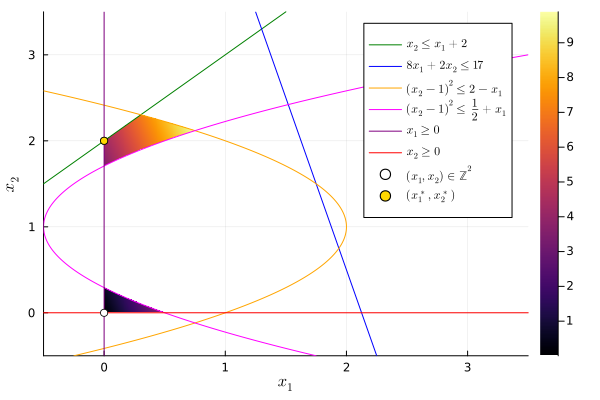

In [22]:
ξ(x1, x2) = χ(x1, x2) && ((x2 - 1)^2 >= 1/2 + x1) # Constraint 4: (x₂ - 1)² ≤ 1/2 + x₁

# Generate the feasible region plot of this problem
n = 1_000

xi1 = xi2 = 0:4

# Plot relaxed feasible region
plt = heatmap(
    x1,
    x2,
    (x1, x2) -> ξ(x1, x2) ? z(x1, x2) : NaN;
    legend=:topright,
    xlims=extrema(x1),
    ylims=extrema(x2),
    xlabel=raw"$ x_1 $",
    ylabel=raw"$ x_2 $",
)

# Make plots of constraints
plot!(plt, x1, (x1) -> x1 + 2;
    label=raw"$ x_2 \leq x_1 + 2 $",
    color=:green,
)
plot!(plt, x1, (x1) -> (17 - 8x1) / 2;
    label=raw"$ 8 x_1 + 2 x_2 \leq 17 $",
    color=:blue,
)
plot!(plt, 2 .- (x1 .- 1) .^ 2, x1,;
    label=raw"$ (x_2 - 1)^2 \leq 2 - x_1 $",
    color=:orange,
)
plot!(plt, -1/2 .+ (x1 .- 1) .^ 2, x1,;
    label=raw"$ (x_2 - 1)^2 \leq \frac{1}{2} + x_1 $",
    color=:magenta,
)

# Nonnegativitivy constraints
plot!(plt, zeros(n), x2;
    label=raw"$ x_1 \geq 0 $",
    color=:purple,
)
plot!(plt, x1, zeros(n);
    label=raw"$ x_2 \geq 0 $",
    color=:red,
)

# Feasible solutions
scatter!(plt,
    [xi1[i] for i = 1:5 for j = 1:5 if ξ(xi1[i], xi2[j])],
    [xi2[j] for i = 1:5 for j = 1:5 if ξ(xi1[i], xi2[j])];
    label=raw"$ (x_1, x_2) \in \mathbb{Z}^2 $",
    color=:white,
)

# Optimal solution LP
scatter!(plt, [xnc[1]], [xnc[2]];
    label=raw"$ (x_1^\ast, x_2^\ast) $",
    color=:gold,
)

We are able to solve non-convex MINLP problems. However, the complexity of these problems leads to significant computational challenges that need to be tackled.

### Powerful commercial solver installation

#### Gurobi Installation

Gurobi is one of the most powerful LP and MIP solvers available today. They provide free academic licenses. In order to install the software, visit their **[Website](https://www.gurobi.com/)**, create an account (preferably with your CMU email), and obtain a license. Once you do that, you can download and use the software.

#### BARON Installation

BARON is one of the most powerful MINLP solvers available today. CMU students are given a free license given by the association of BARON's developer (Prof. Nick Sahinidis) to CMU. In order to install the software, visit their **[Website](https://www.minlp.com/home)**, create an account (with your CMU email), and obtain a license. Once you do that you can download and use the software.